In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, preprocessing
import matplotlib.pyplot as plt
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

To address overfitting problem, I choose to use data augmentation and an additional layer called dropout.

In [2]:
(train_ds, test_ds), metadata = tfds.load(
    'cifar100',
    split=['train[0%:100%]', 'test[0%:100%]'],
    with_info=True,
    as_supervised=True,
)

After loading datasets, I choose a few data augmentation methods, including resize, random crop and random brightness.

In [3]:
IMG_SIZE = 32
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_rescale(image, label)
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    # Make a new seed.
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    # Random crop back to the original size.
    image = tf.image.stateless_random_crop(
        image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
    # Random brightness.
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

rng = tf.random.Generator.from_seed(123, alg='philox')
def f(x, y):
    seed = rng.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

Show images in the dataset.

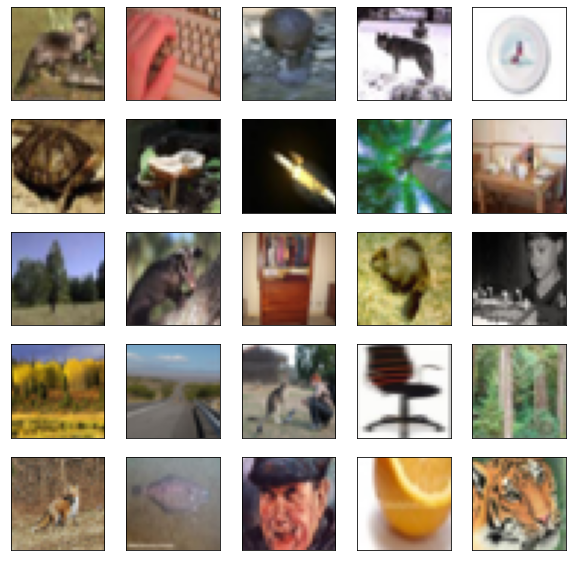

In [24]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()
def show_image(x_dataset, image_index):
    plt.figure(figsize=(10,10))
    for idx in range(25):
        plt.subplot(5,5,idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(x_dataset[image_index+idx][:, :, :].astype(np.uint8))
    plt.show()
    plt.close()
show_image(train_images, 100)

I map these methods to original dataset, to make the dataset more diversity.

In [4]:
batch_size, AUTOTUNE = 32, True
train_ds = (
    train_ds
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

Add a dropout layer to randomly drop some values to 0. This is a common method to make the neural network more generalized.

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.4))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(100))

After training, we can find that the test accuracy is even higher than train accuracy. 

This indicates that our methods are successful which are used to make the algorithm more generalized.

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
                    epochs=30, 
                    validation_data=test_ds)

Epoch 1/30
1563/1563 [==============================] - 27s 16ms/step - loss: 4.2350 - accuracy: 0.0484 - val_loss: 3.8426 - val_accuracy: 0.1086
Epoch 2/30
1563/1563 [==============================] - 22s 14ms/step - loss: 3.8019 - accuracy: 0.1128 - val_loss: 3.5141 - val_accuracy: 0.1646
Epoch 3/30
1563/1563 [==============================] - 22s 14ms/step - loss: 3.5707 - accuracy: 0.1501 - val_loss: 3.2760 - val_accuracy: 0.2095
Epoch 4/30
1563/1563 [==============================] - 16s 10ms/step - loss: 3.4273 - accuracy: 0.1789 - val_loss: 3.1618 - val_accuracy: 0.2336
Epoch 5/30
1563/1563 [==============================] - 17s 11ms/step - loss: 3.3287 - accuracy: 0.1983 - val_loss: 3.0593 - val_accuracy: 0.2499
Epoch 6/30
1563/1563 [==============================] - 25s 16ms/step - loss: 3.2474 - accuracy: 0.2103 - val_loss: 2.9479 - val_accuracy: 0.2688
Epoch 7/30
1563/1563 [==============================] - 17s 11ms/step - loss: 3.1784 - accuracy: 0.2232 - val_loss: 2.8905 -

After plotting them out, we can see more clearly.

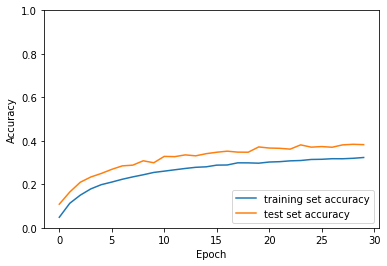

In [25]:
plt.plot(history.history['accuracy'], label='training set accuracy')
plt.plot(history.history['val_accuracy'], label = 'test set accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Finally, let us discuss why we cannot achieve higher accuracy. 

I suppose the reason is that the model is too simple.

By solving overfitting problem, we can use a more complex model to achieve better result.